# User-to-User Product Recommendation by Collaborative Filtering

Data source: Online Retail Data Set from UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/online+retail)

**Load & Prepare the Data**

In [1]:
# Import necessary libraries.
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read data source Excel files.
df1 = pd.read_excel('./data/Online Retail.xlsx')

In [3]:
# Check dataframe information.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Read header of dataframe.
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Check any column containing the null value.
df1.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [6]:
# Count the number of null value records in the CustomerID column.
df1['CustomerID'].isna().sum()

135080

In [7]:
df1a = df1.dropna(subset=['CustomerID'])

In [8]:
# Check dataframe information.
df1a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [9]:
# Read header of dataframe.
df1a.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Create CustomerID vs Item (Purchased Items, by StockCode) matrix by pivot table function.
CustomerID_Item_matrix = df1a.pivot_table(
    index='CustomerID', 
    columns='StockCode', 
    values='Quantity',
    aggfunc='sum'
)

In [11]:
# Display the shape of matrix, 4372 rows of CustomerID, 3684 columns of Item.
CustomerID_Item_matrix.shape

(4372, 3684)

In [12]:
# Update illustration of the matrix, 1 to represent customer have purchased item, 0 to represent customer haven't purchased.
CustomerID_Item_matrix = CustomerID_Item_matrix.applymap(lambda x: 1 if x > 0 else 0)

In [13]:
# Read header of CustomerID vs Item matrix.
CustomerID_Item_matrix.loc[12680:].head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12680.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12681.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12682.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12683.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12684.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


**Calculate the User to User similarity by Cosine Similarity**

In [14]:
# Create User to User similarity matrix. 
user_to_user_similarity_matrix = pd.DataFrame(
    cosine_similarity(CustomerID_Item_matrix)
)

In [15]:
# Display header of User to User similarity matrix. 
user_to_user_similarity_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,1.000000,0.063022,0.046130,0.047795,0.038814,0.0,0.025876,0.136641,0.094742,...,0.0,0.0,0.054656,0.0,0.032844,0.062318,0.0,0.113776,0.109364,0.012828
2,0.0,0.063022,1.000000,0.024953,0.051709,0.027995,0.0,0.027995,0.118262,0.146427,...,0.0,0.0,0.118262,0.0,0.000000,0.000000,0.0,0.000000,0.170905,0.083269
3,0.0,0.046130,0.024953,1.000000,0.056773,0.138314,0.0,0.030737,0.032461,0.144692,...,0.0,0.0,0.000000,0.0,0.039014,0.000000,0.0,0.067574,0.137124,0.030475
4,0.0,0.047795,0.051709,0.056773,1.000000,0.031846,0.0,0.000000,0.000000,0.033315,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.044866,0.000000


In [16]:
# Update index to corresponding CustomerID.
user_to_user_similarity_matrix.columns = CustomerID_Item_matrix.index
user_to_user_similarity_matrix['CustomerID'] = CustomerID_Item_matrix.index
user_to_user_similarity_matrix = user_to_user_similarity_matrix.set_index('CustomerID')

In [17]:
# Display header of User to User similarity matrix. 
user_to_user_similarity_matrix.head()

CustomerID,12346.0,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
12347.0,0.0,1.000000,0.063022,0.046130,0.047795,0.038814,0.0,0.025876,0.136641,0.094742,...,0.0,0.0,0.054656,0.0,0.032844,0.062318,0.0,0.113776,0.109364,0.012828
12348.0,0.0,0.063022,1.000000,0.024953,0.051709,0.027995,0.0,0.027995,0.118262,0.146427,...,0.0,0.0,0.118262,0.0,0.000000,0.000000,0.0,0.000000,0.170905,0.083269
12349.0,0.0,0.046130,0.024953,1.000000,0.056773,0.138314,0.0,0.030737,0.032461,0.144692,...,0.0,0.0,0.000000,0.0,0.039014,0.000000,0.0,0.067574,0.137124,0.030475
12350.0,0.0,0.047795,0.051709,0.056773,1.000000,0.031846,0.0,0.000000,0.000000,0.033315,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.044866,0.000000


In [18]:
# Randomly pick CustomerID (12702) to display the most similar CustomerID.
# The most similar CustomerID is 14608, which has 51% similarity.
user_to_user_similarity_matrix.loc[12702.0].sort_values(ascending=False)

CustomerID
12702.0    1.000000
14608.0    0.510310
15758.0    0.481125
18259.0    0.444444
15434.0    0.427121
             ...   
14895.0    0.000000
14896.0    0.000000
14897.0    0.000000
14898.0    0.000000
15301.0    0.000000
Name: 12702.0, Length: 4372, dtype: float64

In [19]:
# Display CustomerID (12702) purchased items.
items_purchased_by_X = set(CustomerID_Item_matrix.loc[12702.0].iloc[
    CustomerID_Item_matrix.loc[12702.0].to_numpy().nonzero()].index)
items_purchased_by_X

{21479,
 21481,
 22111,
 22113,
 22114,
 22835,
 23355,
 23356,
 23357,
 23439,
 '84032A',
 'POST'}

In [20]:
# Display CustomerID (14608) purchased items.
items_purchased_by_Y = set(CustomerID_Item_matrix.loc[14608.0].iloc[
    CustomerID_Item_matrix.loc[14608.0].to_numpy().nonzero()].index)
items_purchased_by_Y

{21481, 22111, 22112, 22114, 22207, 23355, 23357, '84029E'}

In [21]:
# Find out items which purchased by X (12702) but not yet purchased by Y (14608).
items_to_recommend_to_Y = items_purchased_by_X - items_purchased_by_Y

In [22]:
# Display the list of items recommended for Y (14608).
items_to_recommend_to_Y

{21479, 22113, 22835, 23356, 23439, '84032A', 'POST'}

In [23]:
# Display the list of items recommended for Y (14608) with item Description.
df1a.loc[
    df1a['StockCode'].isin(items_to_recommend_to_Y), 
    ['StockCode', 'Description']
].drop_duplicates().set_index('StockCode')

,Description
StockCode,
POST,POSTAGE
22835,HOT WATER BOTTLE I AM SO POORLY
21479,WHITE SKULL HOT WATER BOTTLE
22113,GREY HEART HOT WATER BOTTLE
84032A,CHARLIE+LOLA PINK HOT WATER BOTTLE
23356,LOVE HOT WATER BOTTLE
23439,HAND WARMER RED LOVE HEART


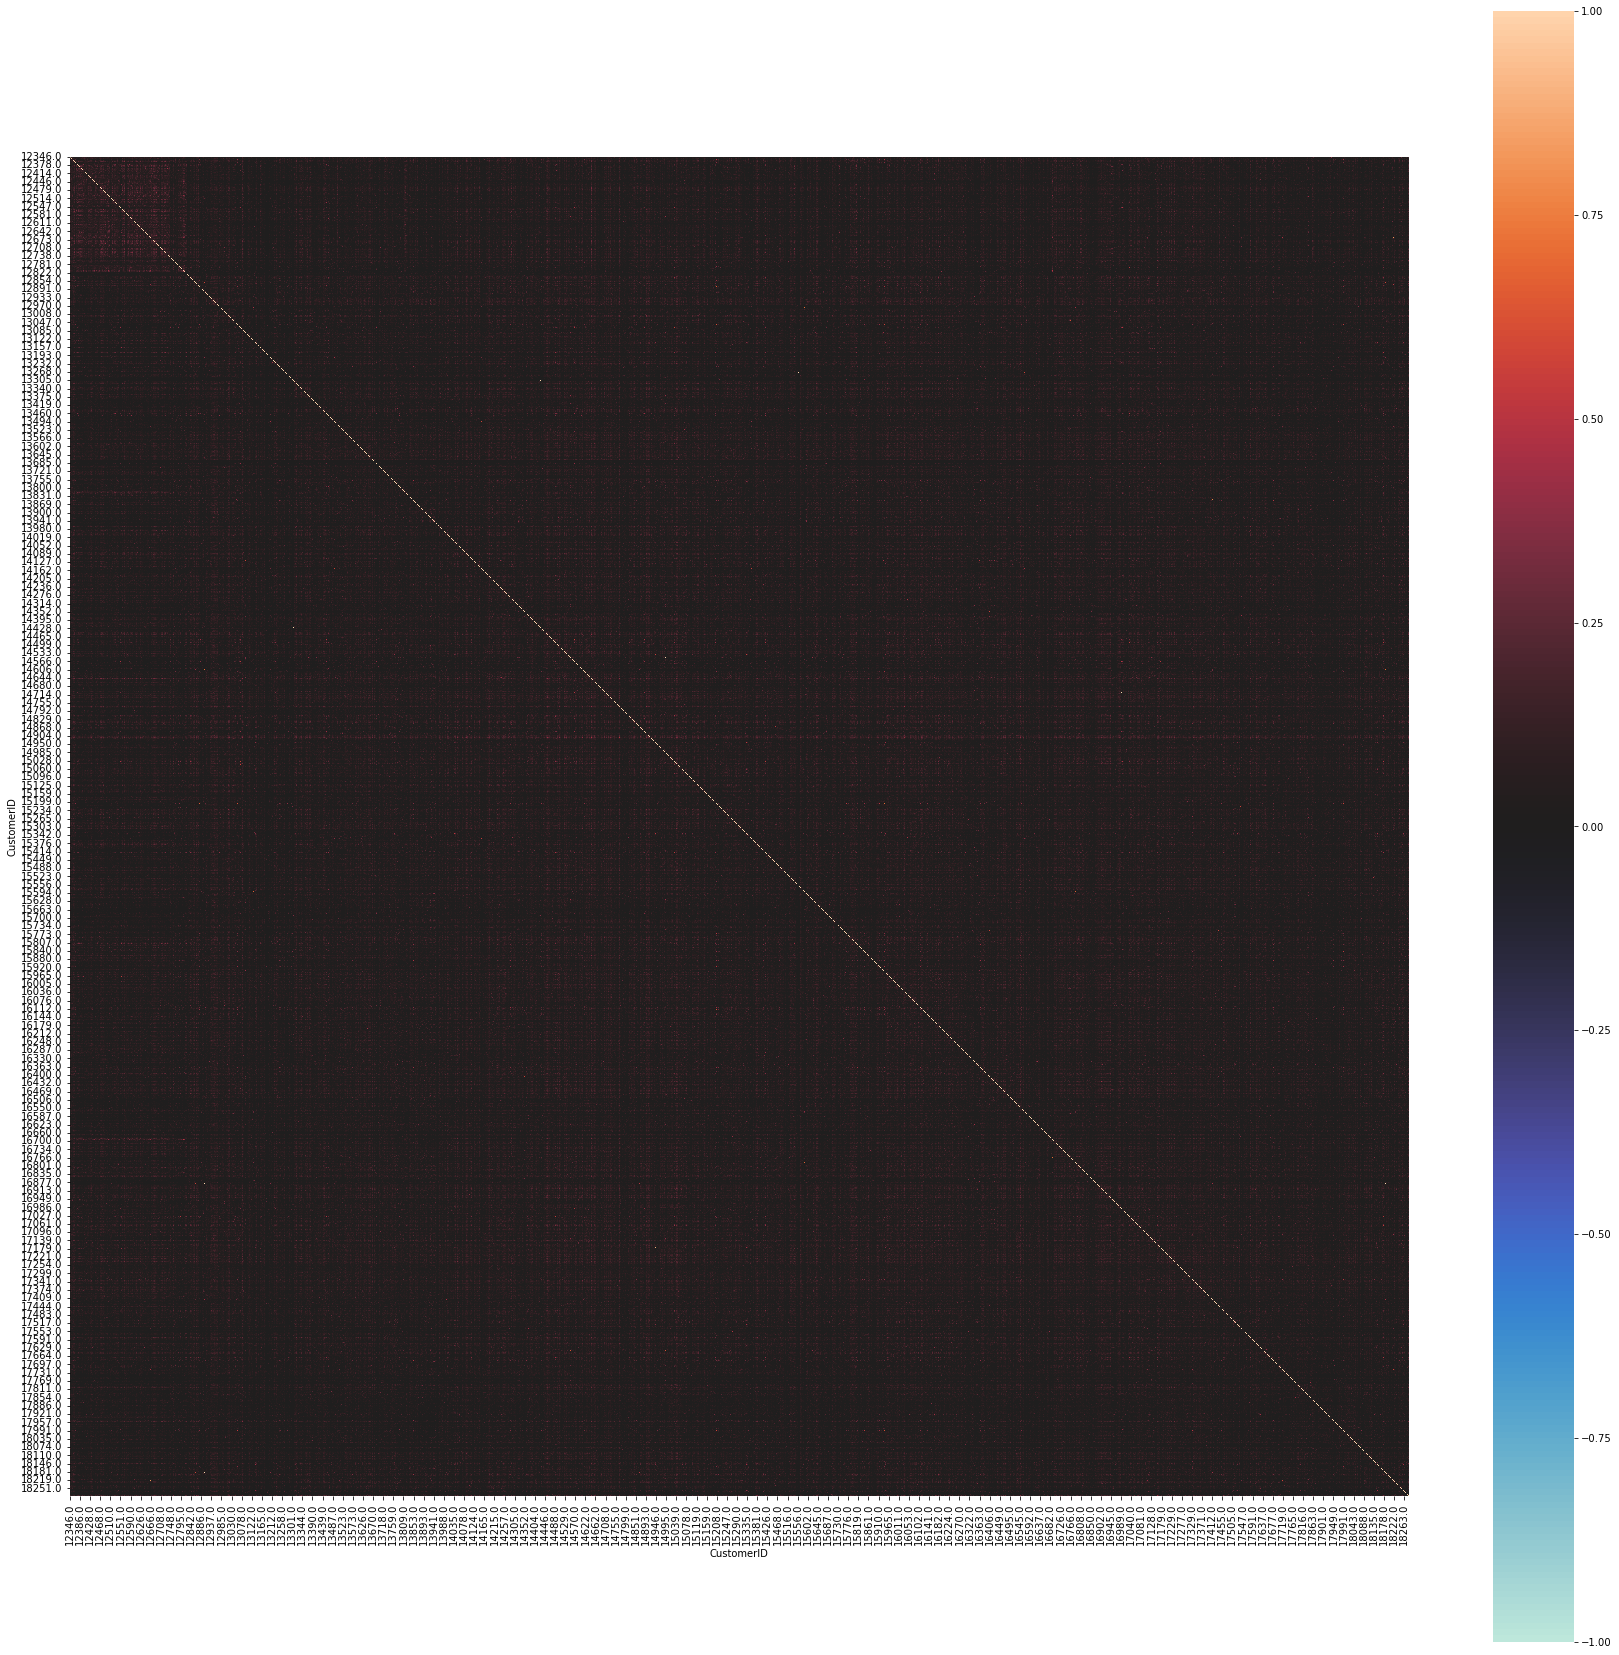

In [28]:
# And optionally, use the heatmap to display the User to User similarity matrix.
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))
ax = sns.heatmap(
    user_to_user_similarity_matrix, 
    vmin=-1, vmax=1, center=0,
    square=True)